# Modeling TF-IDF + SVM (LinearSVC) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [13]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

sys.path.append(os.path.abspath('..'))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna,
    sample_class_weight_value
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

**a) LinearSVC with basic preprocessed data**

In [14]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 1.0015187038934632, 'select__k': 70, 'positive_class_weight': 10}
Best F2 score during optimization: 0.844

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


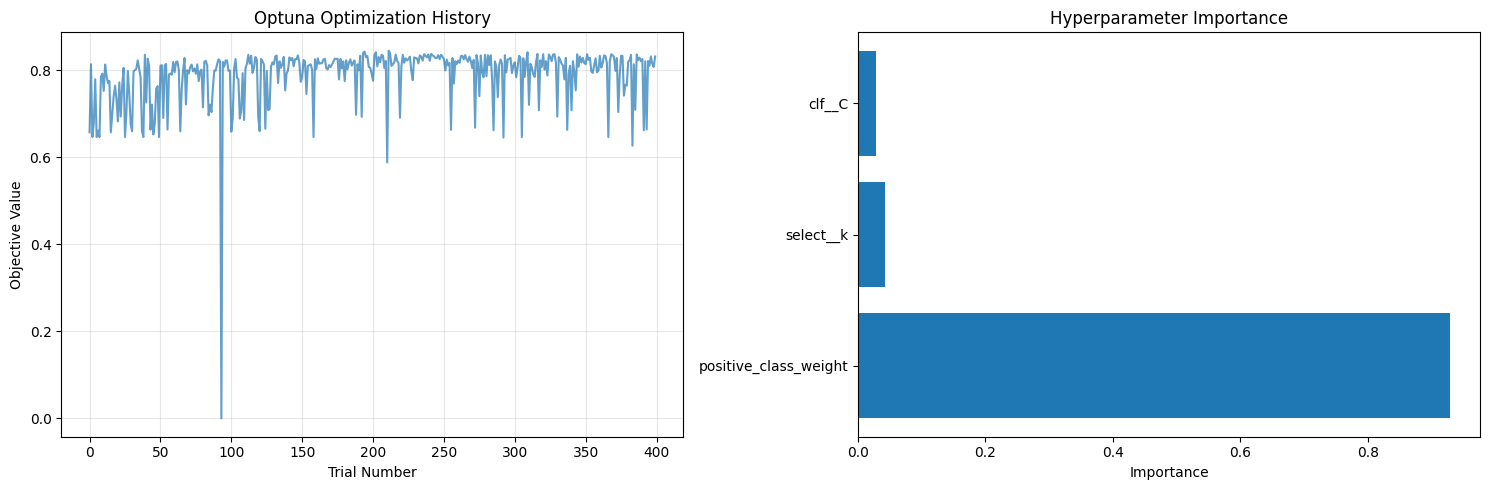


2. Parameter Value Distributions:


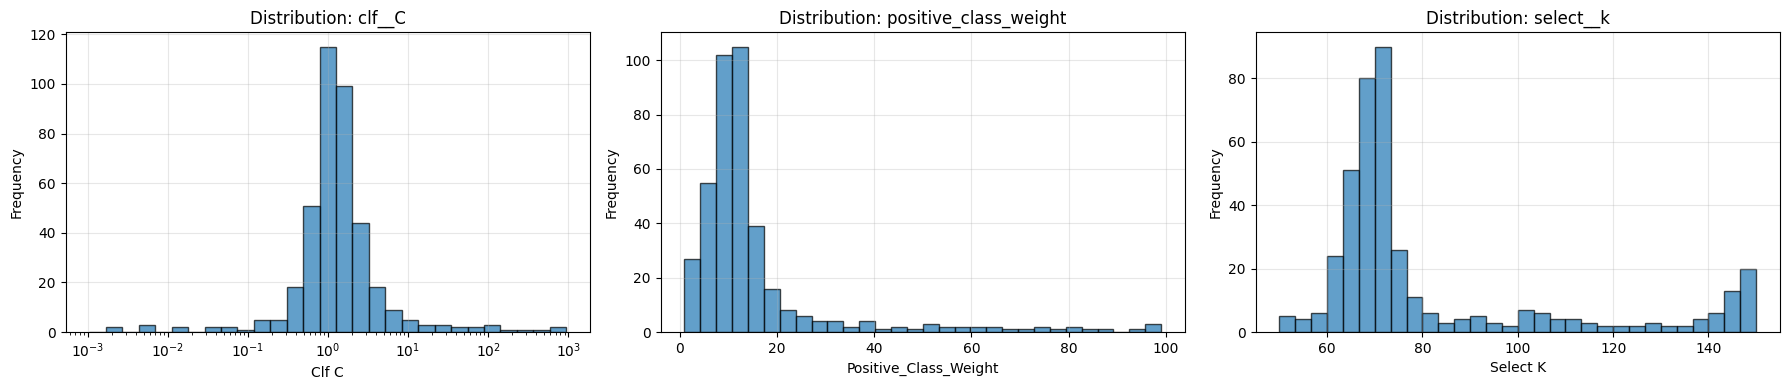


3. Performance vs Individual Parameters:


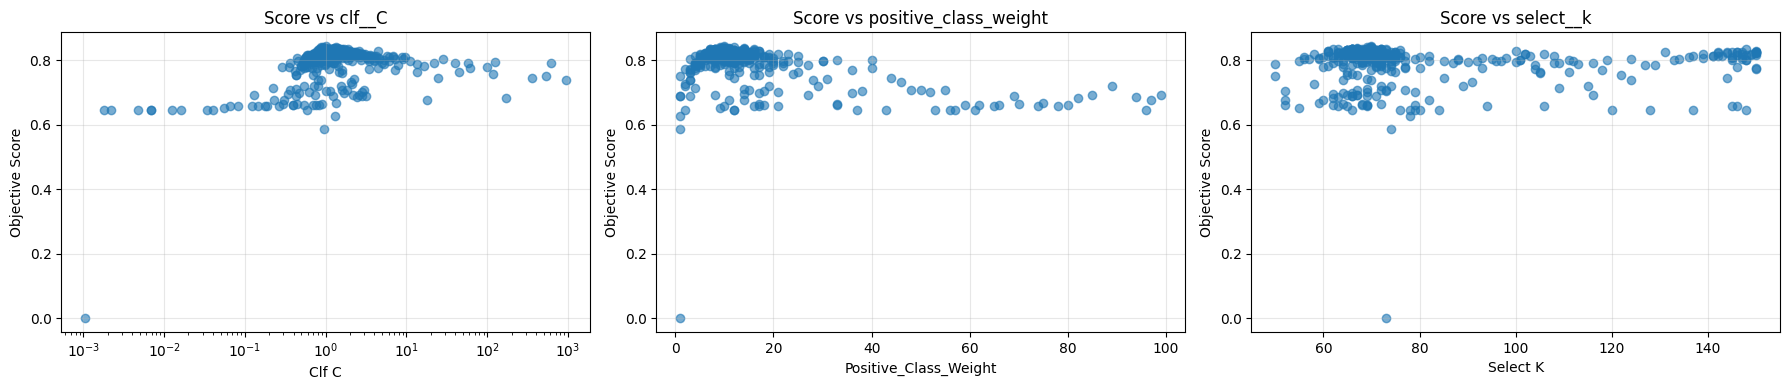


4. Convergence Analysis:


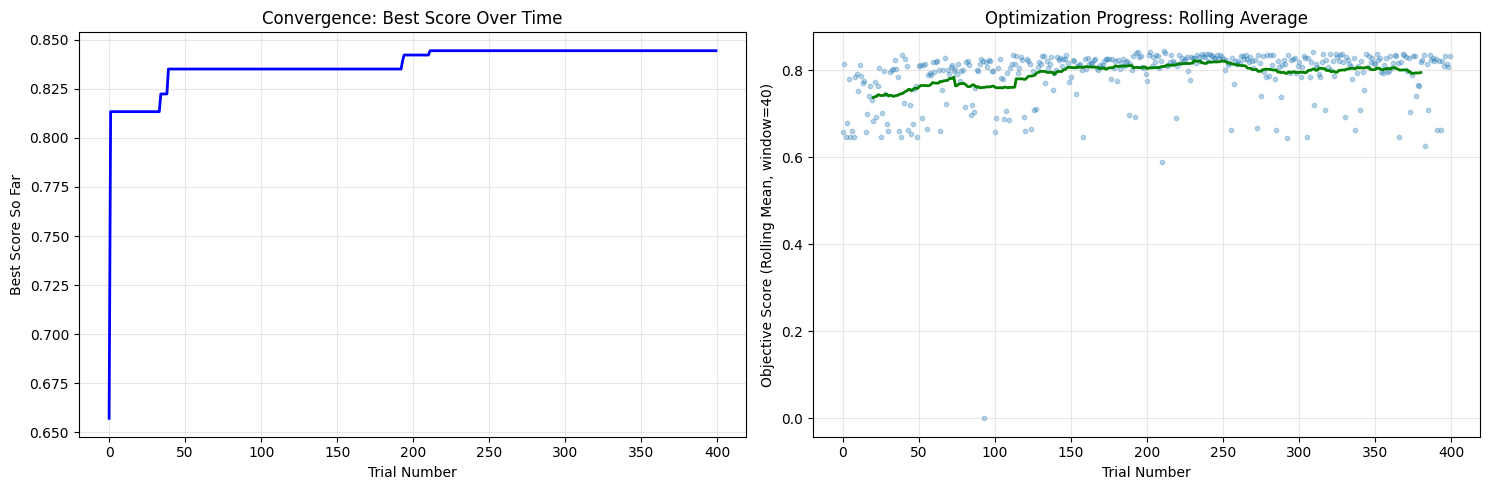


5. Trial Status Overview:


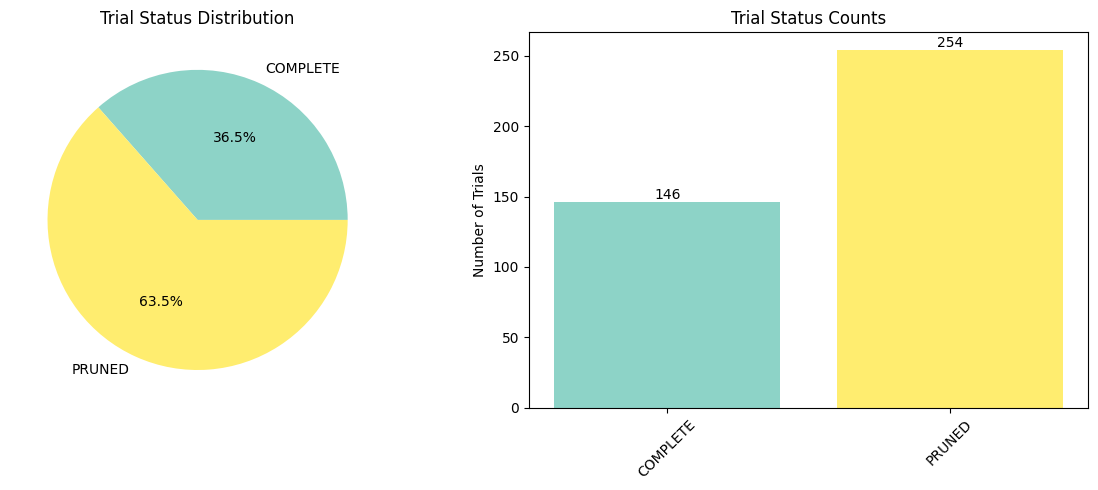


6. Top 10 Best Trials:
Rank Trial#  Score      C            positive_class_weight k           
-----------------------------------------------------------------------
1    211     0.8444     1.0015       10           70          
2    194     0.8422     0.8815       9            70          
3    309     0.8409     1.3299       12           69          
4    202     0.8408     0.9202       10           70          
5    193     0.8394     0.8750       10           70          
6    212     0.8392     0.9880       9            70          
7    241     0.8372     1.3746       11           67          
8    316     0.8370     1.2610       14           70          
9    320     0.8365     1.2681       11           69          
10   328     0.8364     1.4923       14           69          

7. Study Statistics Summary:
• Total trials: 400
• Successful trials: 400
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #211
• Best objective value: 0.8444
• Score statistics:
  - Mean: 0.788

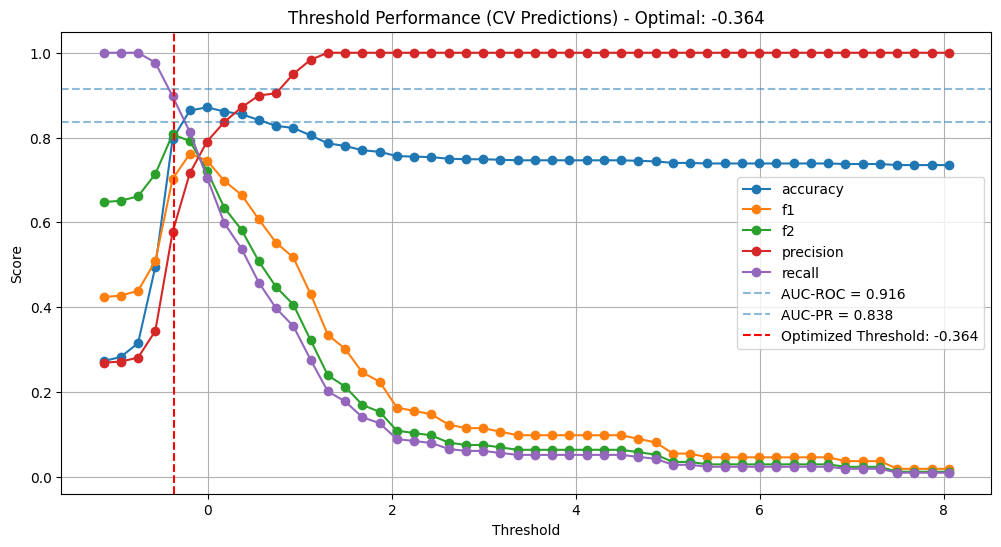

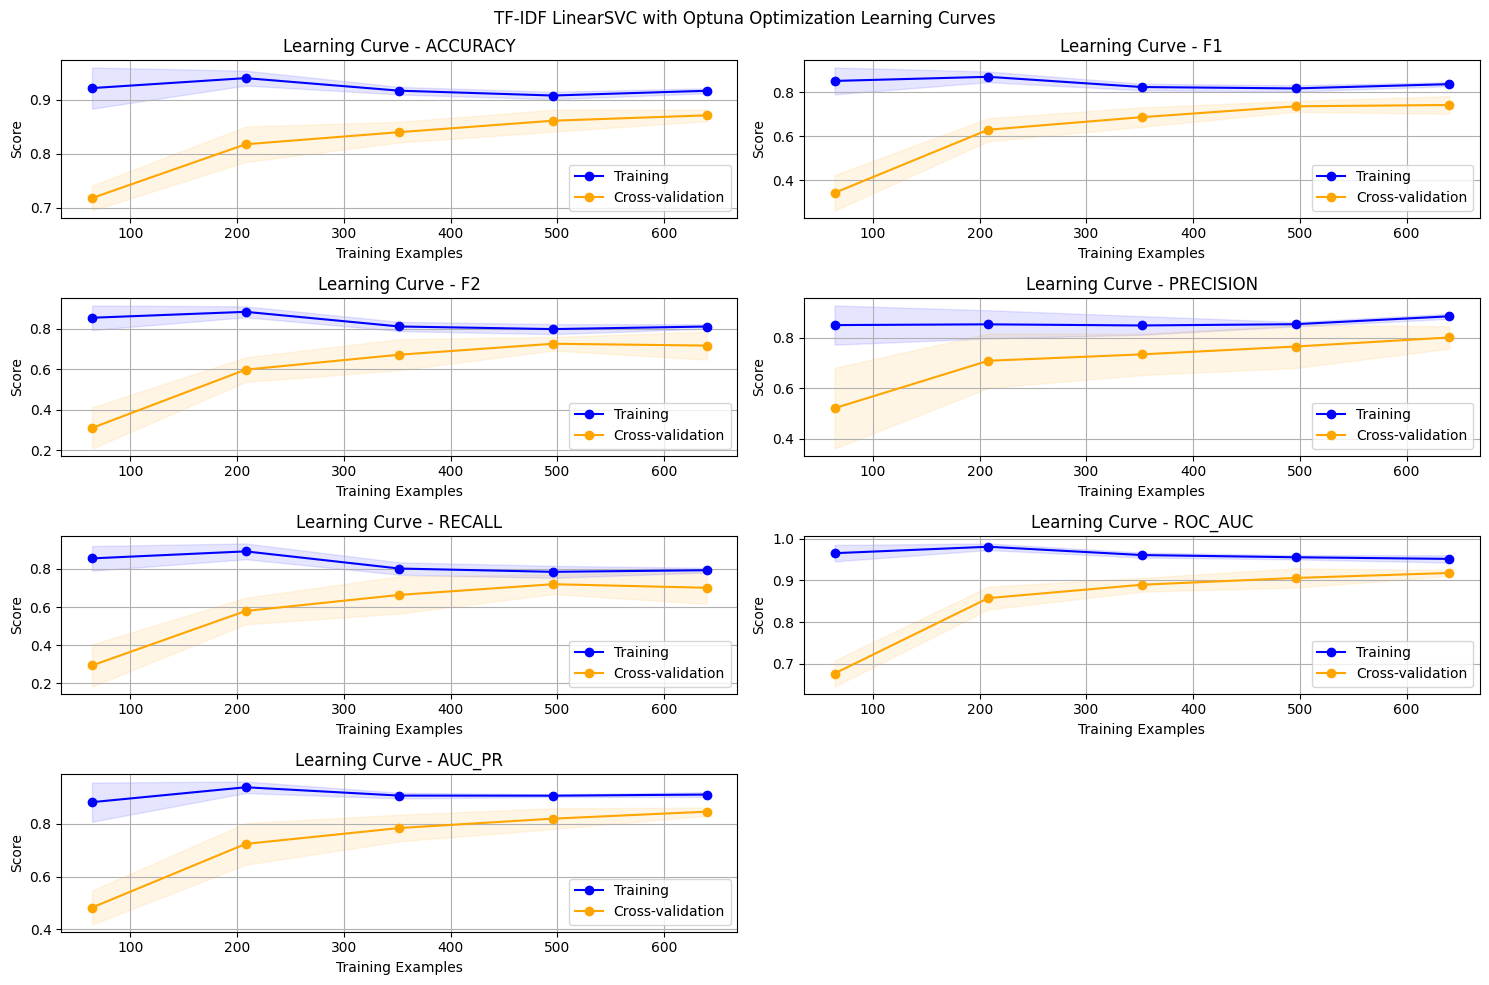


Final Threshold: -0.36

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       146
           1       0.68      0.81      0.74        54

    accuracy                           0.84       200
   macro avg       0.80      0.84      0.81       200
weighted avg       0.86      0.84      0.85       200

Additional Metrics:
Accuracy   0.845
F2-score   0.783
AUC-ROC    0.916
AUC-PR     0.813



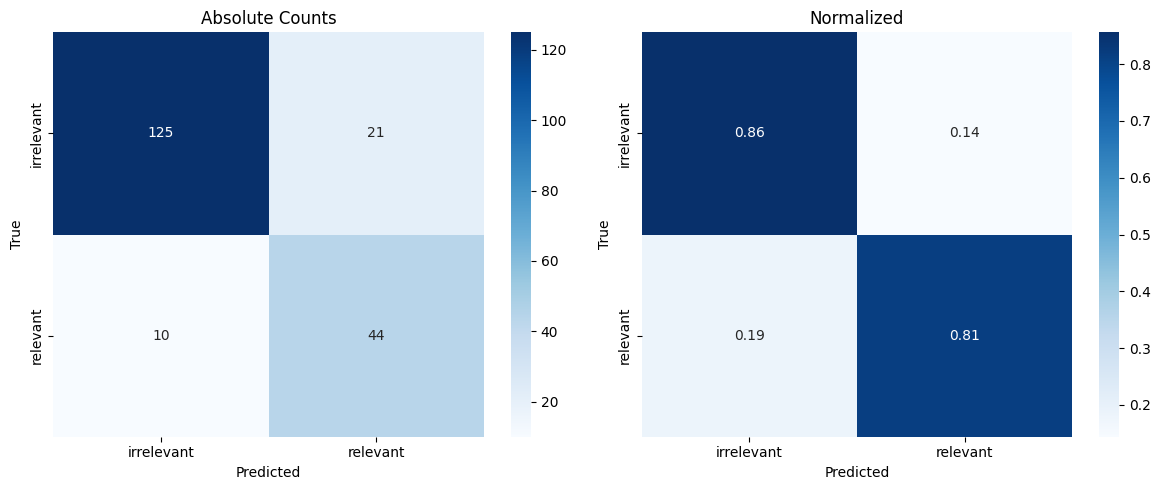

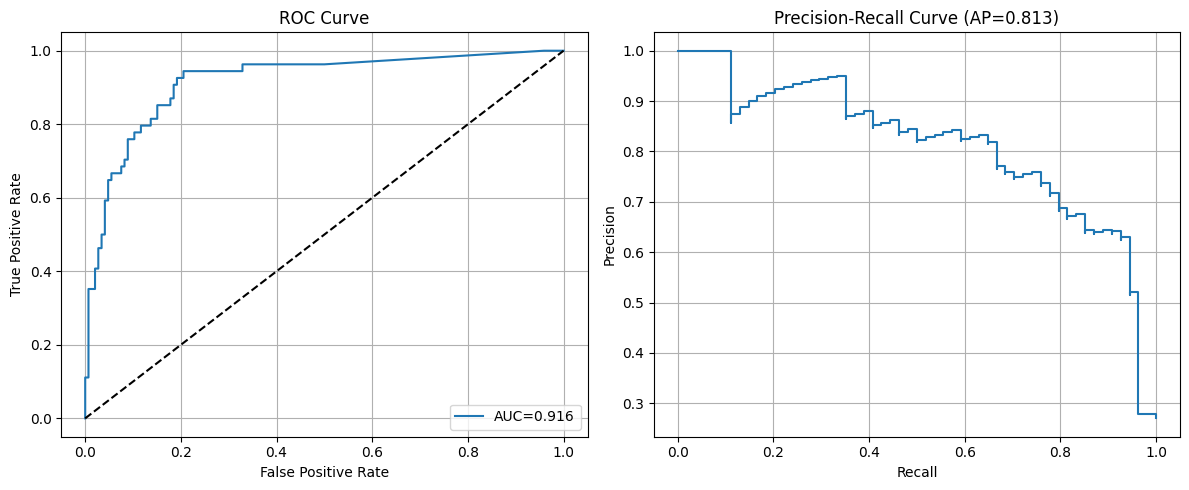


Model saved as 'model_tfidf_linearsvc_basic.joblib'


In [15]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a LinearSVC classifier 
pipeline_tfidf_linearsvc = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    class_weight="balanced",#default, will be changed by Optuna
                    random_state=42,
                    max_iter=5000
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 150),
    "clf__class_weight": lambda trial: sample_class_weight_value(trial, low=1, high=100)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_linearsvc,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=400,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_linearsvc_basic"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LinearSVC with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + LinearSVC (Basic Preprocessing)',
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_linearsvc_basic.joblib")

print(f"\nModel saved as 'model_tfidf_linearsvc_basic.joblib'")

**b) with advanced preprocessed data**

In [16]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # advanced cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

Starting Optuna hyperparameter optimization ...
Best parameters found by Optuna TPE: {'clf__C': 1.827077543761371, 'select__k': 118, 'positive_class_weight': 17}
Best F2 score during optimization: 0.877

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


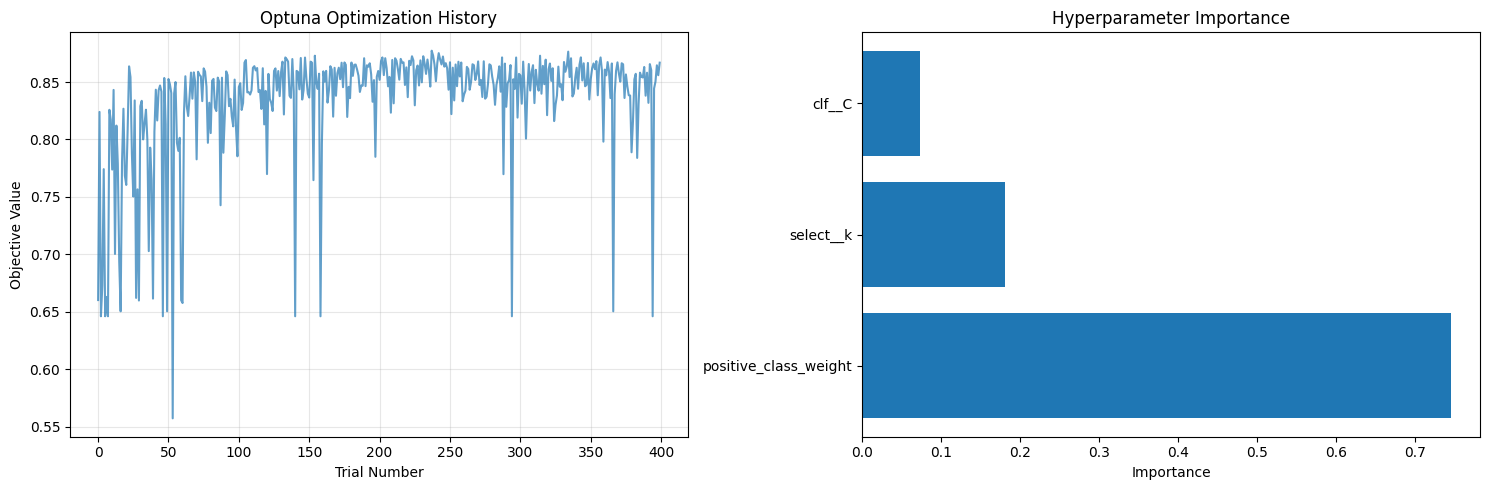


2. Parameter Value Distributions:


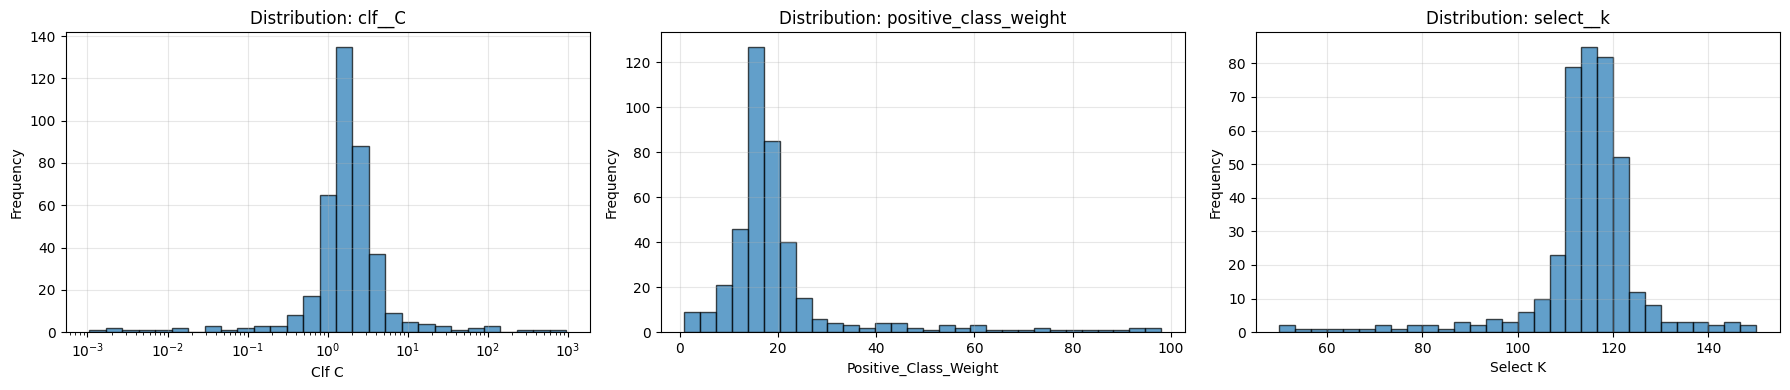


3. Performance vs Individual Parameters:


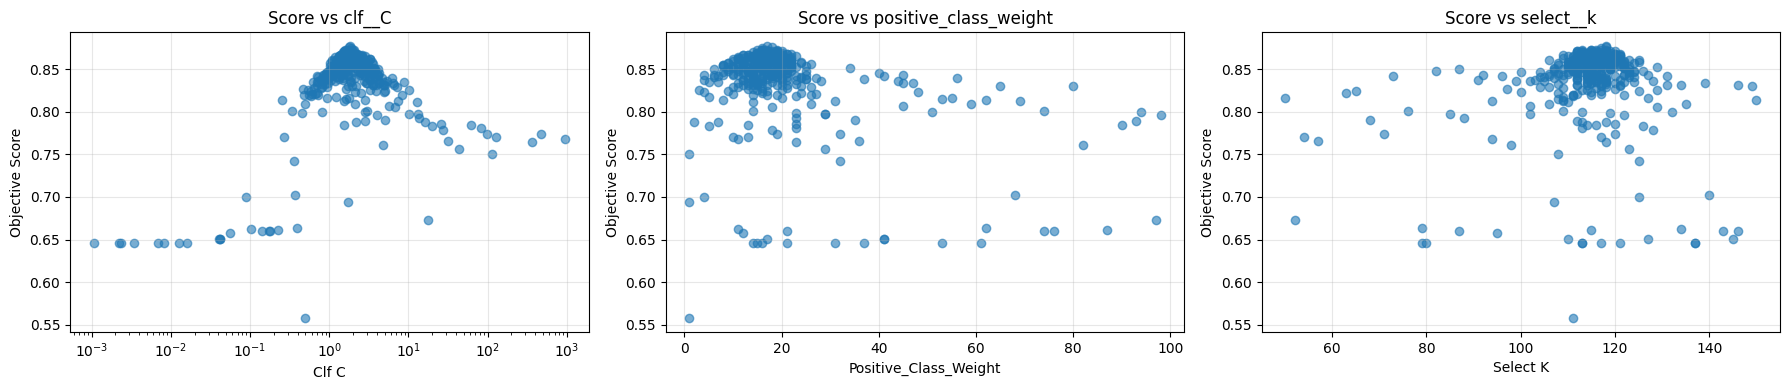


4. Convergence Analysis:


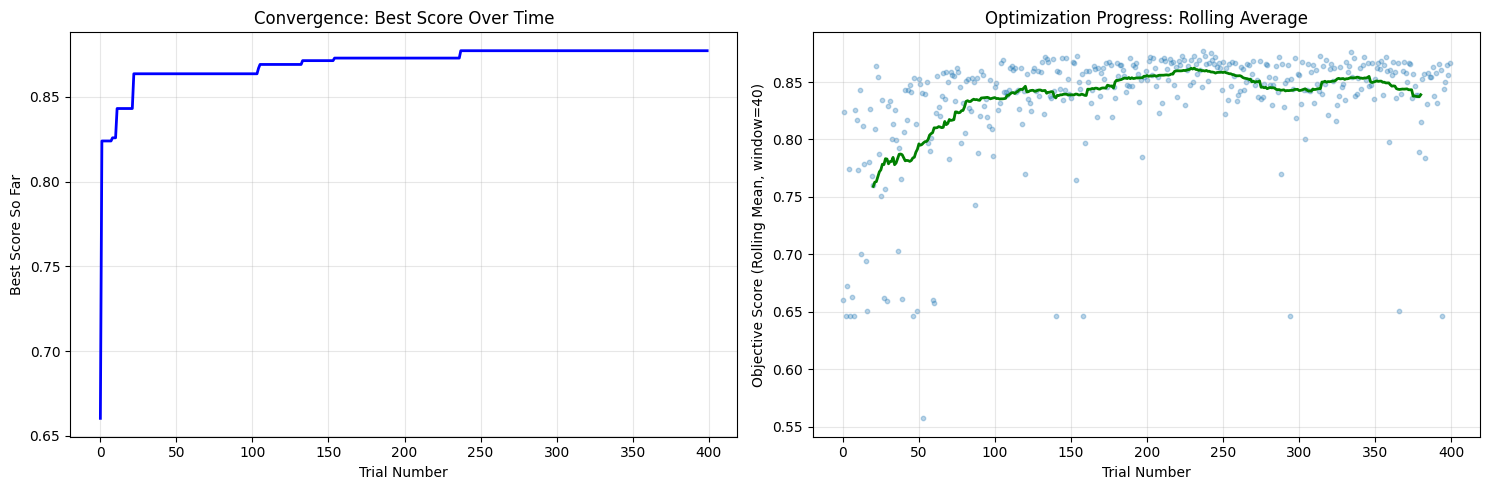


5. Trial Status Overview:


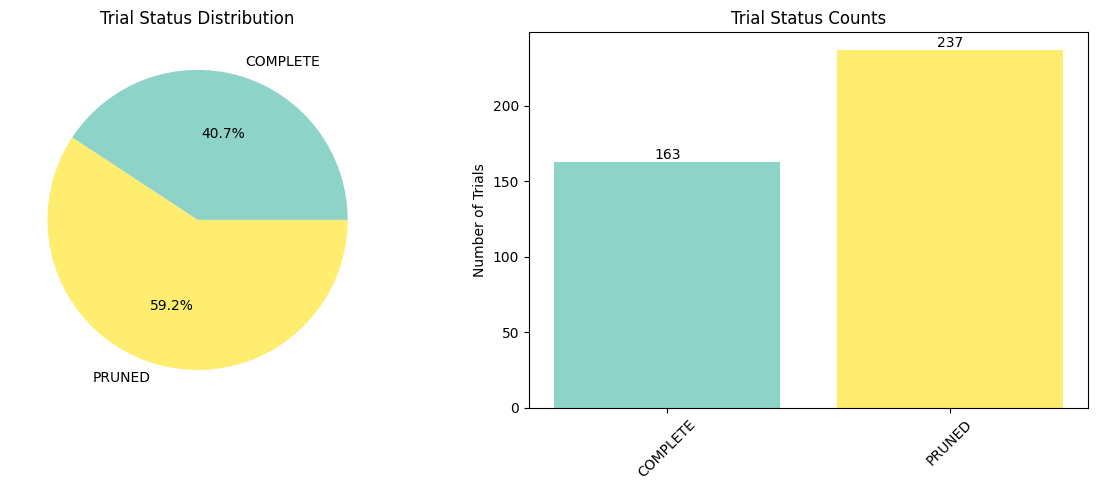


6. Top 10 Best Trials:
Rank Trial#  Score      C            positive_class_weight k           
-----------------------------------------------------------------------
1    237     0.8773     1.8271       17           118         
2    334     0.8765     1.7713       18           118         
3    242     0.8752     1.8594       16           117         
4    238     0.8731     1.9866       16           118         
5    154     0.8729     2.0510       19           113         
6    314     0.8729     1.6558       17           116         
7    223     0.8724     1.8876       15           115         
8    231     0.8724     1.9090       16           115         
9    245     0.8722     1.5969       16           117         
10   343     0.8715     1.6539       19           120         

7. Study Statistics Summary:
• Total trials: 400
• Successful trials: 400
• Failed trials: 0
• Success rate: 100.0%
• Best trial: #237
• Best objective value: 0.8773
• Score statistics:
  - Mean: 0.834

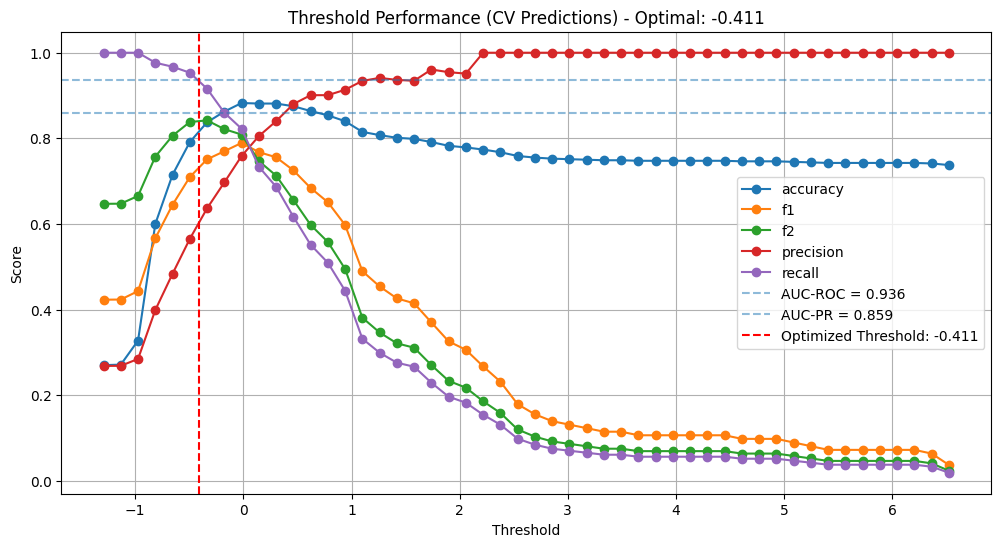

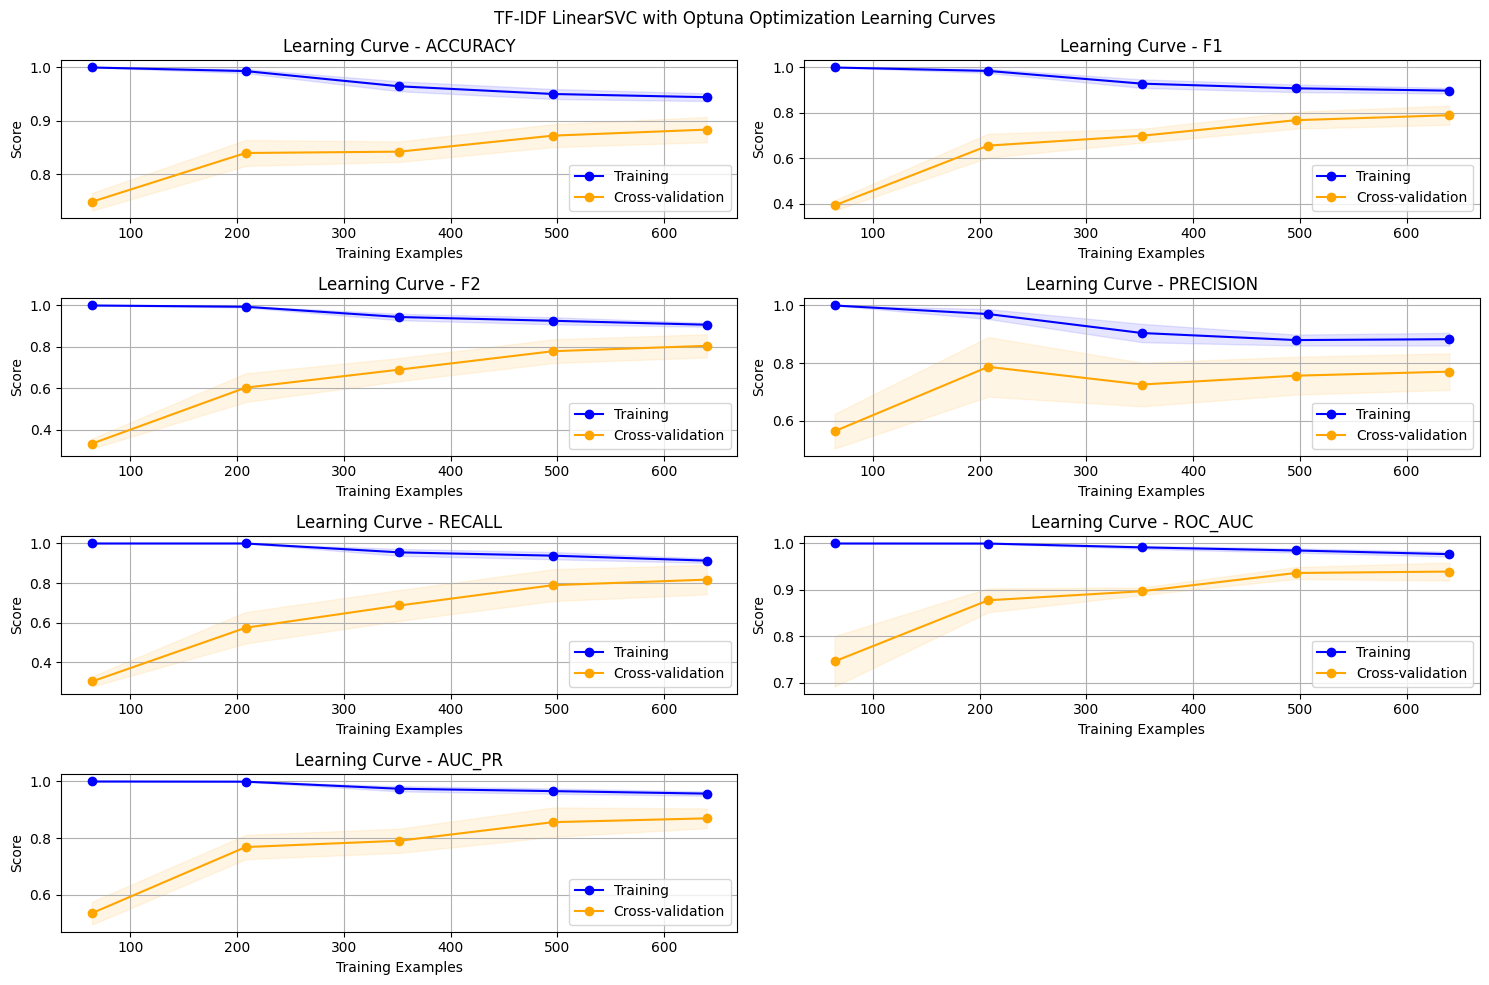


Final Threshold: -0.41

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       146
           1       0.59      0.89      0.71        54

    accuracy                           0.80       200
   macro avg       0.77      0.83      0.78       200
weighted avg       0.85      0.80      0.81       200

Additional Metrics:
Accuracy   0.800
F2-score   0.805
AUC-ROC    0.916
AUC-PR     0.839



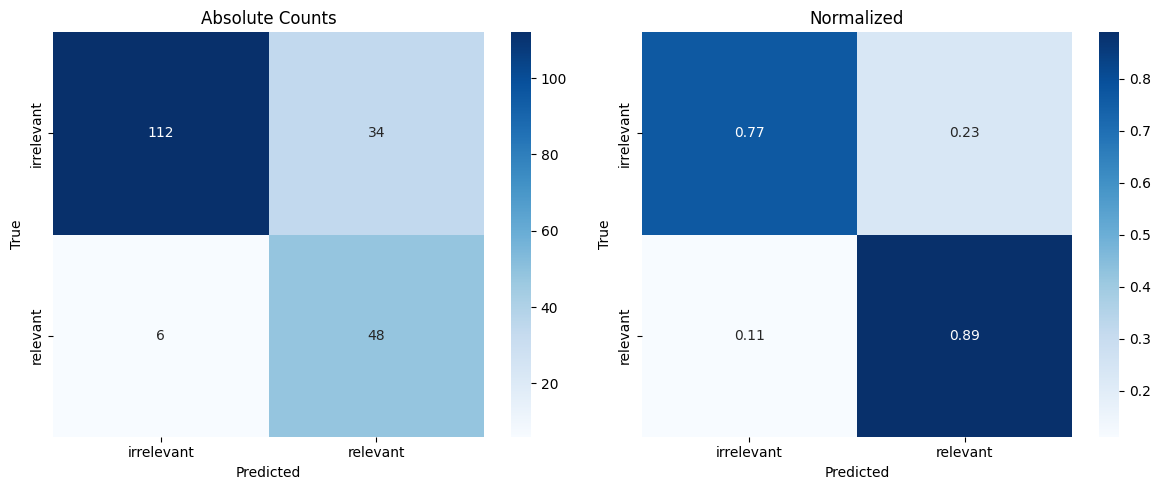

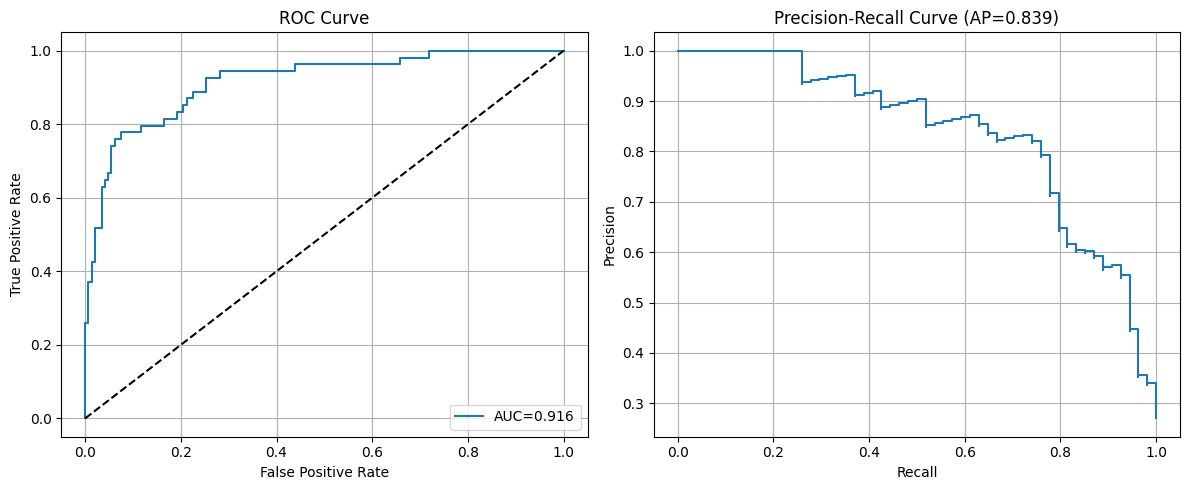


Model saved as 'model_tfidf_linearsvc_advanced.joblib'


In [19]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a LinearSVC classifier 
pipeline_tfidf_linearsvc = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True)),
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     LinearSVC(
                    penalty="l1",
                    dual=False,  # Use dual=False for L1 penalty
                    class_weight="balanced",#default, will be changed by Optuna
                    random_state=42,
                    max_iter=5000
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space using TPE Algorithm
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# Using flexible class_weight sampling with continuous range
param_space = {
    "clf__C": lambda trial: trial.suggest_float("clf__C", 1e-3, 1e3, log=True),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 150),
    "clf__class_weight": lambda trial: sample_class_weight_value(trial, low=1, high=100)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_linearsvc,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=400,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_linearsvc_advanced"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF LinearSVC with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.decision_function(X_test) #predict_proba not available for LinearSVC, using decision_function

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.decision_function(X_dev) #predict_proba not available for LinearSVC, using decision_function
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + LinearSVC (Advanced Preprocessing)',
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_linearsvc_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_linearsvc_advanced.joblib'")